In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

## 1. Exploratory data-analysis


In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Visualizations of character frequencies in the reviews

In [5]:
df['review_len'] = df.review.apply(lambda x: len(x))

array([[<Axes: title={'center': 'review_len'}>]], dtype=object)

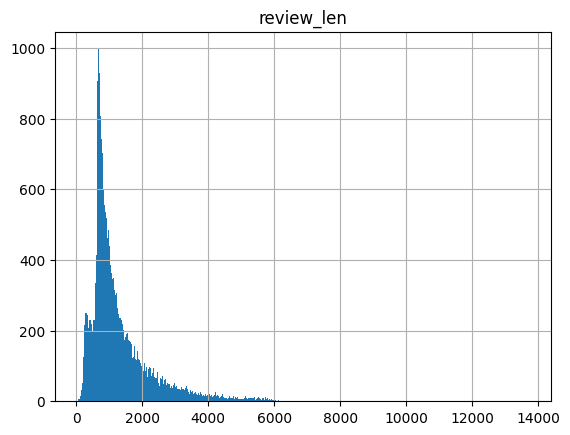

In [6]:
df.hist('review_len', bins=1000)

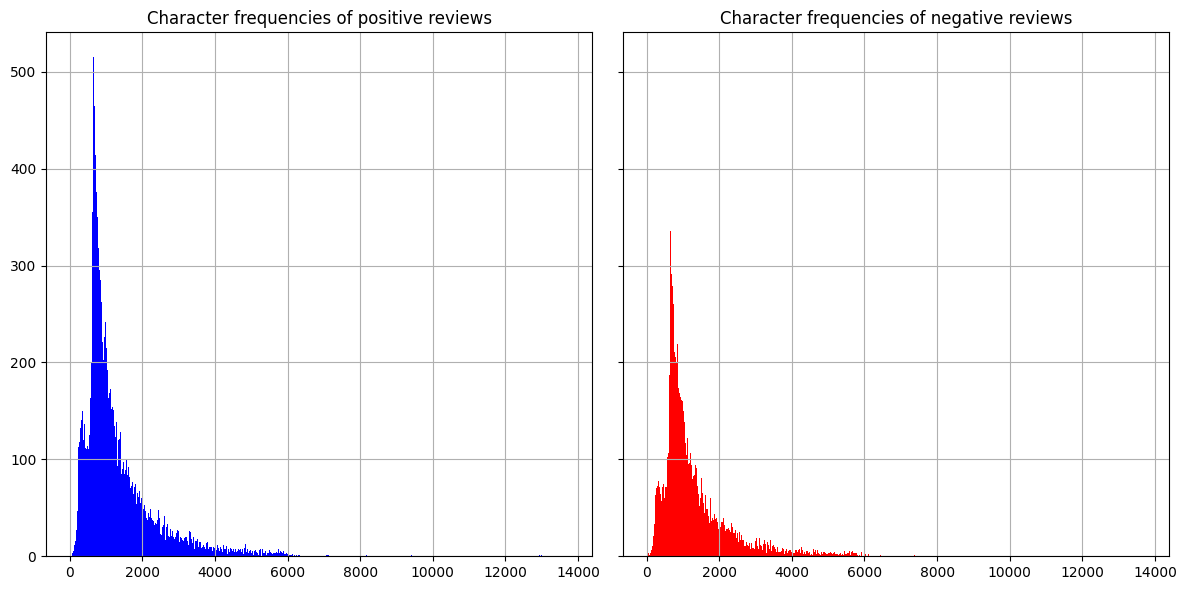

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
ax[0].hist(df.review_len[df.sentiment == 'positive'], bins=1000, color='blue')
ax[0].set_title('Character frequencies of positive reviews')
ax[0].grid(True)
ax[1].hist(df.review_len[df.sentiment == 'negative'], bins=1000, color='red')
ax[1].set_title('Character frequencies of negative reviews')
ax[1].grid(True)
fig.tight_layout()
plt.show()

In [8]:
print('Character frequency statistics of positive reviews\n', df.review_len[df.sentiment == 'positive'].describe())
print()
print('Character frequency statistics of negative reviews\n', df.review_len[df.sentiment == 'negative'].describe())

Character frequency statistics of positive reviews
 count    25000.000000
mean      1324.797680
std       1031.492627
min         65.000000
25%        691.000000
50%        968.000000
75%       1614.000000
max      13704.000000
Name: review_len, dtype: float64

Character frequency statistics of negative reviews
 count    25000.000000
mean      1294.064360
std        945.892669
min         32.000000
25%        706.000000
50%        973.000000
75%       1567.250000
max       8969.000000
Name: review_len, dtype: float64


### Key insights:
- No missing data
- Two labels (positive vs. negative) -> Binary classification problem
- Explanatory data is in text format
- The reviews contain noise: HTML, punctuation, stopwords.

## 2. Data preprocessing
In the exploratory analysis, it was seen that some noise was found in the data for example in the form of HTML markup and punctuation.
In this project we will focus only on analysing the words, that will say the letters, although it could be interesting to see whether there is a correlation e.g. between the labels and number of question marks or exclamation marks found in the review.

The preprocessing pipeline in short is:
1. Getting rid of redundant characters and symbols
2. Stopword removal
3. Stemming

In [9]:
# 0. initial review
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
# Define function that performs preprocessing for given review text.

STOP_WORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()
VECTORIZER = CountVectorizer()

def preprocessor(review):
    # remove HTML
    review = re.sub(r'<.*?>', '', review)
    # remove every non-letter character
    review = re.sub(r'[^A-Za-z]',' ', review)
    # lowercase
    review = review.lower()
    # remove whitespace and split to string
    review = word_tokenize(review)
    # remove stopwords and stem the rest
    review = ' '.join([STEMMER.stem(word) for word in review if word not in STOP_WORDS])
    return review

In [11]:
df['preprocessed'] = df.review.apply(preprocessor)

In [12]:
df.preprocessed[0]

'one review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

In [13]:
df.head()

,review,sentiment,review_len,preprocessed
0,One of the other reviewers has mentioned that ...,positive,1761,one review mention watch oz episod hook right ...
1,A wonderful little production. <br /><br />The...,positive,998,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,926,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,748,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei love time money visual stun film...


### Train-test-split


In [14]:
train, test = train_test_split(df, test_size=0.2)

## 3. Feature engineering

Next, the explanatory data, which is in text format, should be represented in numerical form such that it can be utilized for optimizing the Machine Learning models.

### Feature extraction - Bag of Words

In [15]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train.preprocessed)
X_test = vectorizer.transform(test.preprocessed)

In [16]:
X_train.shape, X_test.shape

((40000, 64417), (10000, 64417))

### Dimensionality reduction

In [17]:
from sklearn.decomposition import TruncatedSVD

In [18]:
pca = TruncatedSVD(n_components=1000)
X_train_svd = pca.fit_transform(X_train)
X_test_svd = pca.transform(X_test)

In [19]:
X_train_svd.shape, X_test_svd.shape

((40000, 1000), (10000, 1000))

### Labels

In [20]:
y_train, y_test = train.sentiment, test.sentiment

## 4. Models

### Logistic Regression

In [21]:
lr = LogisticRegression(penalty='l2',
                        dual=False,
                        tol=1e-4,
                        C=1.0,
                        fit_intercept=True,
                        intercept_scaling=1,
                        solver='lbfgs',
                        max_iter=1000,
                        verbose=0
                       )
lr_model = lr.fit(X_train_svd, y_train)
lr_predictions= lr_model.predict(X_test_svd)

## Multilayer Perceptron classifier

In [22]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001
    )
mlp = mlp.fit(X_train_svd, y_train)
mlp_pred = mlp.predict(X_test_svd)

## 5. Results

### Results for Logistic Regression

In [23]:
report = classification_report(y_test, lr_predictions, digits=3)
print(report)

              precision    recall  f1-score   support

    negative      0.881     0.867     0.874      4934
    positive      0.873     0.886     0.879      5066

    accuracy                          0.877     10000
   macro avg      0.877     0.877     0.877     10000
weighted avg      0.877     0.877     0.877     10000



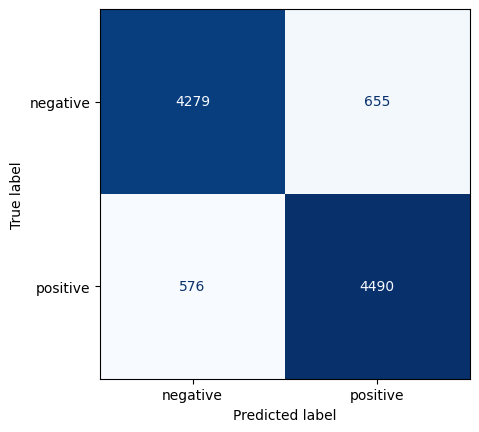

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test,
                                        lr_predictions,
                                        cmap='Blues',
                                        colorbar=False)



### Results for Multilayer Perceptron

In [25]:
report = classification_report(y_test, mlp_pred, digits=3)
print(report)

              precision    recall  f1-score   support

    negative      0.868     0.867     0.868      4934
    positive      0.871     0.871     0.871      5066

    accuracy                          0.870     10000
   macro avg      0.869     0.869     0.869     10000
weighted avg      0.869     0.870     0.869     10000



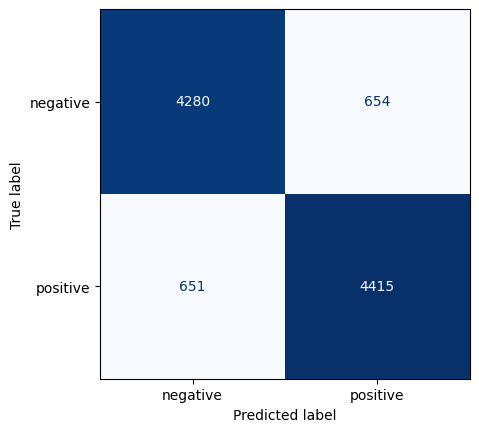

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test,
                                        mlp_pred,
                                        cmap='Blues',
                                        colorbar=False
                                        )